<img src='logo.png'><br>
* ref : https://www.kaggle.com/vijayuv/onlineretail

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import re
import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)


# Data Load

In [2]:
df = pd.read_csv("./dataset/OnlineRetail.csv",  
                 encoding='unicode_escape', 
                 parse_dates=['InvoiceDate'])
print(df.shape)
print(df.info())
df.head()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 가공
* InvoiceDate   object  --> datetime64[ns]  ---> read_csv시 parse_dates로 처리
* CustomerID    결측인 레코드 삭제
* CustomerID    float   --> int64
* InvoiceNo     object  --> int64 

## CustomerID 
* 결측 레코드 삭제, 타입변환

In [3]:
idx = df[df['CustomerID'].isna()].index
print(df.shape)
print(idx[:5])
df = df.drop(idx, axis=0)
print(df.shape)

(541909, 8)
Int64Index([622, 1443, 1444, 1445, 1446], dtype='int64')
(406829, 8)


In [4]:
df['CustomerID'] = df['CustomerID'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int32         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 26.4+ MB


## InvoiceNo
* by hjprak

In [5]:
error_NO = set(i[0] for i in df['InvoiceNo'].values if re.findall('[^0-9]', i))
print(error_NO)

{'C'}


In [6]:
# df[df['InvoiceNo'] == '536379']
# df[df['InvoiceNo'].str.contains('C')]
# df['InvoiceNo'].str.extract("([a-zA-Z]+)")
df['InvoiceNo'] = df['InvoiceNo'].str.extract(r"(\d+)").astype('int64')  #C544117 --> 544117

## Country   
* United Kingdom만 사용

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

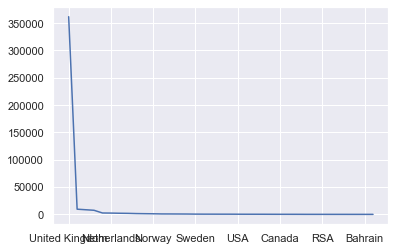

In [7]:
print(df['Country'].value_counts())
df['Country'].value_counts().plot()
plt.show()

In [8]:
df = df[df['Country'] == 'United Kingdom'].copy()
df['Country'].value_counts()

United Kingdom    361878
Name: Country, dtype: int64

In [9]:
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000,361878.000000
mean,560631.447435,11.077029,3.256007,15547.871368
std,13166.072218,263.129266,70.654731,1594.402590
min,536365.000000,-80995.000000,0.000000,12346.000000
25%,549169.000000,2.000000,1.250000,14194.000000
50%,561884.000000,4.000000,1.950000,15514.000000
75%,572282.000000,12.000000,3.750000,16931.000000
max,581586.000000,80995.000000,38970.000000,18287.000000


In [10]:
df = df.drop('Country', axis=1)

## Quantity
* 거래량이 (-) 데이터 삭제

In [11]:
df[df['Quantity'] < 0].shape

(7533, 7)

In [12]:
idx = df[df['Quantity'] < 0].index
print(df.shape)
df = df.drop(idx, axis=0)
print(df.shape)

(361878, 7)
(354345, 7)


## UnitPrice
* 거래대금이 0 데이터 삭제

In [13]:
df[df['UnitPrice'] <= 0].shape

(24, 7)

In [14]:
idx = df[df['UnitPrice'] <= 0].index
print(df.shape)
df = df.drop(idx, axis=0)
print(df.shape)

(354345, 7)
(354321, 7)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  int64         
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(2)
memory usage: 20.3+ MB


# RFM
* 가치있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법으로 알려져 있어 마케팅에서 가장 많이 사용되는 분석기법<br><br>
* R (Recency)  :  최근 (InvoiceDate)
* F (Frequency) : 빈도 (InvoiceNo, StockCode)
* M (Monetary) : 수량 ( Quantity*UnitPrice)


## R (Recency) : 최근 (InvoiceDate)

In [16]:
df['InvoiceDate'].min(),  df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [17]:
df['day_diff'] =  df['InvoiceDate'].max() - df['InvoiceDate']

In [18]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,day_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,373 days 04:23:00


In [19]:
df['day_diff'] = df['day_diff'].apply(lambda x : x.days+1)

In [20]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,day_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,374


In [21]:
df[df['InvoiceDate'] == df['InvoiceDate'].max()].head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,day_diff
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,1


In [22]:
df = df.set_index('InvoiceDate')
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,day_diff
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,374


## F (Frequency) : 빈도 (InvoiceNo, StockCode)

In [23]:
df[['InvoiceNo','StockCode']].value_counts().head()

InvoiceNo  StockCode
555524     22698        20
           22697        12
572861     22775         8
578289     23395         7
572344     M             7
dtype: int64

## M (Monetary) : 수량 ( Quantity*UnitPrice)

In [24]:
df['monetary'] = df['Quantity'] * df['UnitPrice']

In [25]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,day_diff,monetary
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,374,15.3


# user별 RFM 분석

* R : day_diff : max
* F : InvoiceNo, CustomerID : count
* M : monetary : sum

In [26]:
# R=pd.DataFrame(df['day_diff'].groupby('CustomerID').max())
# F=pd.DataFrame(df['InvoiceNo'].groupby(df['CustomerID']).count())
# M=pd.DataFrame(df['monetary'].groupby(df['CustomerID']).sum())
# RFM=pd.concat([R,F,M],axis=1)
# RFM.columns=['Recency','Frequency','Monetary']

In [27]:
rfm = df.groupby('CustomerID').agg({'day_diff': 'max', 
                                    'InvoiceNo': 'count', 
                                    'monetary': 'sum'})
rfm.head(1)

,day_diff,InvoiceNo,monetary
CustomerID,,,
12346,326,1,77183.6


In [28]:
rfm = rfm.reset_index()
rfm.head(1)

,CustomerID,day_diff,InvoiceNo,monetary
0,12346,326,1,77183.6


In [29]:
rfm.columns = ['CustomerID','R','F','M']
rfm.head(1)

,CustomerID,R,F,M
0,12346,326,1,77183.6


In [30]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3920 non-null   int64  
 1   R           3920 non-null   int64  
 2   F           3920 non-null   int64  
 3   M           3920 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 122.6 KB


# 고객 군집 모델
* 휴면/이탈/VVIP 선별

In [31]:
rfm.describe()

,CustomerID,R,F,M
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,223.553571,90.388010,1864.385601
std,1576.594671,118.070706,217.808385,7482.817477
min,12346.000000,1.000000,1.000000,3.750000
25%,14208.750000,112.000000,17.000000,300.280000
50%,15569.500000,249.000000,41.000000,652.280000
75%,16913.250000,327.000000,99.250000,1576.585000
max,18287.000000,374.000000,7847.000000,259657.300000


## 검증 & 시각화 공통함수
* 엘보차트 -- n_cluseter
* PCA - 2차 차원축소
* scatter 군집 시각화 -- sil_score

In [32]:
def my_clustering(X, cluser_list=[2,3,4,5,6]):
    pca = PCA(n_components=2, random_state=1234)
    pca_X = pca.fit_transform(X)  #원본, StandardScaler, LogScaler
    print("explained_variance_ratio_:", pca.explained_variance_ratio_)
    
    p, axes = plt.subplots(1, len(cluser_list)+1, figsize=(20,5))
    list = []
    for i, k in enumerate(cluser_list):
        model = KMeans(n_clusters=k, random_state=1234)
        model.fit(pca_X)
        pred = model.predict(pca_X)  #cluster_label
        print(f"{k} SCORE: {silhouette_score(pca_X , pred)}")

        # for p in set(pred):
        sns.scatterplot(x=pca_X[:,0], y=pca_X[:,1], hue=pred, ax=axes[i])
        
        #------엘보차트------
        print(k , model.inertia_)
        list.append(model.inertia_)
    axes[5].plot(cluser_list, np.array(list))
    plt.show()

## 원본

In [33]:
rfm = rfm.set_index('CustomerID')
rfm.head()

,R,F,M
CustomerID,,,
12346,326,1,77183.60
12747,369,103,4196.01
12748,374,4595,33719.73
12749,213,199,4090.88
12820,327,59,942.34


explained_variance_ratio_: [9.99002170e-01 7.63980924e-04]
2 SCORE: 0.9747982262815945
2 91302336280.59361
3 SCORE: 0.957957997054988
3 30888347946.74401
4 SCORE: 0.8410929129412178
4 19377573902.094524
5 SCORE: 0.8119478446326406
5 13109012914.296747
6 SCORE: 0.811852712436243
6 9037802672.863003


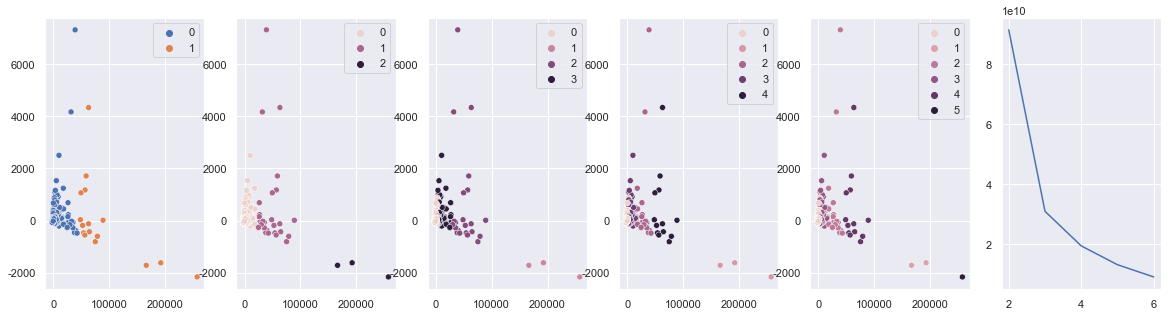

In [34]:
my_clustering(rfm)

## StandardScaler

explained_variance_ratio_: [0.48810717 0.28907626]
2 SCORE: 0.5303293896441685
2 5911.398991018056
3 SCORE: 0.5530168943518513
3 2903.0731870680206
4 SCORE: 0.5786742756181078
4 1942.6713586731767
5 SCORE: 0.49000916280682694
5 1454.724921419427
6 SCORE: 0.4997669838040933
6 1035.2294957691029


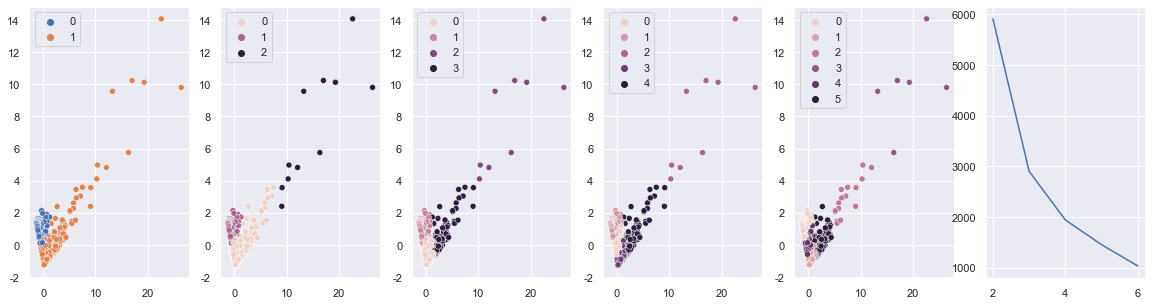

In [35]:
scaler = StandardScaler()
rfm_scaler = scaler.fit_transform(rfm)
my_clustering(rfm_scaler)

## 로그변환 

explained_variance_ratio_: [0.65454546 0.26582169]
2 SCORE: 0.41955261005691874
2 5725.531655519274
3 SCORE: 0.44367625698720137
3 3659.1782068350994
4 SCORE: 0.39873640336840577
4 2722.452763655095
5 SCORE: 0.40245955617704393
5 2253.729766213408
6 SCORE: 0.37505389485824847
6 1874.8544449969281


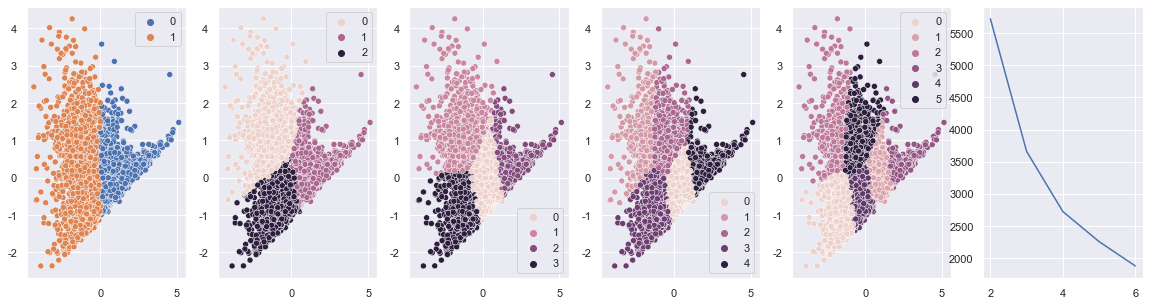

In [36]:
rfm['R'] =  np.log1p(rfm['R'])
rfm['F'] =  np.log1p(rfm['F'])
rfm['M'] =  np.log1p(rfm['M'])

rfm_log_scaler = scaler.fit_transform(rfm)
my_clustering(rfm_log_scaler)

# 고객유형분석
* LogScaler - 군집
* n_cluster : 4


In [37]:
# rfm['R'] =  np.log1p(rfm['R'])
# rfm['F'] =  np.log1p(rfm['F'])
# rfm['M'] =  np.log1p(rfm['M'])
# rfm_log_scaler = scaler.fit_transform(rfm)
temp = pd.DataFrame(data=rfm_log_scaler, index=rfm.index)
temp.head()

,0,1,2
CustomerID,,,
12346,0.720669,-2.403387,3.785914
12747,0.860671,0.732578,1.444280
12748,0.875883,3.739419,3.119983
12749,0.240200,1.251577,1.423880
12820,0.724130,0.296025,0.243880


In [38]:
pca = PCA(n_components=2, random_state=1234)
pca_X = pca.fit_transform(rfm_log_scaler)  #원본, StandardScaler, LogScaler

model = KMeans(n_clusters=4, random_state=1234)
model.fit(pca_X)
pred = model.predict(pca_X)  #cluster_label
print(f"SCORE: {silhouette_score(pca_X , pred)}")

SCORE: 0.39873640336840577


In [39]:
temp['cluster_label'] =  pred.reshape(-1,1)
temp.columns = ['R','F','M','cluster_label']
temp.head()

,R,F,M,cluster_label
CustomerID,,,,
12346,0.720669,-2.403387,3.785914,0
12747,0.860671,0.732578,1.444280,2
12748,0.875883,3.739419,3.119983,2
12749,0.240200,1.251577,1.423880,2
12820,0.724130,0.296025,0.243880,0


In [40]:
rfm['R'] =  np.expm1(rfm['R'])
rfm['F'] =  np.expm1(rfm['F'])
rfm['M'] =  np.expm1(rfm['M'])
rfm['cluster_label'] =  pred.reshape(-1,1)

In [52]:
rfm['F_M'] = np.round((rfm['M'] / rfm['F']) * 100, 1)
rfm.head()

,R,F,M,cluster_label,mon_per_day,M_F,F_M
CustomerID,,,,,,,
12346,326.0,1.0,77183.60,0,7718360.0,7718360.0,7718360.0
12747,369.0,103.0,4196.01,2,4073.8,4073.8,4073.8
12748,374.0,4595.0,33719.73,2,733.8,733.8,733.8
12749,213.0,199.0,4090.88,2,2055.7,2055.7,2055.7
12820,327.0,59.0,942.34,0,1597.2,1597.2,1597.2


In [53]:
res = rfm.groupby('cluster_label').agg({'R': 'mean', 
                                    'F': 'mean', 
                                    'M': 'mean',
                                    'F_M' : 'mean' })
res.head()

,R,F,M,F_M
cluster_label,,,,
0,259.557562,56.610986,1010.745803,9528.228442
1,46.331633,35.227041,481.154096,3096.231250
2,307.678879,259.857759,5783.028654,9467.637823
3,238.370876,11.739477,251.689397,4838.262344


In [50]:
idx = rfm[rfm['cluster_label'] ==3].index
idx[:5]

Int64Index([12821, 12829, 12831, 12834, 12837], dtype='int64', name='CustomerID')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354321 entries, 2010-12-01 08:26:00 to 2011-12-09 12:49:00
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    354321 non-null  int64  
 1   StockCode    354321 non-null  object 
 2   Description  354321 non-null  object 
 3   Quantity     354321 non-null  int64  
 4   UnitPrice    354321 non-null  float64
 5   CustomerID   354321 non-null  int32  
 6   day_diff     354321 non-null  int64  
 7   monetary     354321 non-null  float64
dtypes: float64(2), int32(1), int64(3), object(2)
memory usage: 23.0+ MB


In [54]:
df[df['CustomerID'].isin(idx)].head(10)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,day_diff,monetary
InvoiceDate,,,,,,,,
2010-12-01 09:09:00,536374,21258,VICTORIAN SEWING BOX LARGE,32,10.95,15100,374,350.40
2010-12-01 09:53:00,536384,82484,WOOD BLACK BOARD ANT WHITE FINISH,3,6.45,18074,374,19.35
2010-12-01 09:53:00,536384,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,48,0.65,18074,374,31.20
2010-12-01 09:53:00,536384,22464,HANGING METAL HEART LANTERN,12,1.65,18074,374,19.80
2010-12-01 09:53:00,536384,21324,HANGING MEDINA LANTERN SMALL,6,2.95,18074,374,17.70
2010-12-01 09:53:00,536384,22457,NATURAL SLATE HEART CHALKBOARD,12,2.95,18074,374,35.40
2010-12-01 09:53:00,536384,22469,HEART OF WICKER SMALL,40,1.45,18074,374,58.00
2010-12-01 09:53:00,536384,22470,HEART OF WICKER LARGE,40,2.55,18074,374,102.00
2010-12-01 09:53:00,536384,22224,WHITE LOVEBIRD LANTERN,6,2.95,18074,374,17.70
